# Deep Learning Homework2
Akwasi Darkwah Akwaboah <br>
03/10/2021


## Dataset

In [2]:
import numpy as np
from scipy.io import loadmat
from numpy.random import permutation as perm
np.random.seed(1000)

#Data import
x = loadmat('YaleB_32x32.mat')
fea = x['fea']
gnd = x['gnd']

def data_split(X, Y, s):
    idx_train = []
    #unique number labels instead merely setting it to 38
    #make it more generic
    for i in np.unique(gnd):
        idx_k = np.where(Y==i)[0]
        np.random.shuffle(idx_k)
        idx_train.append(idx_k[:s])
    #length(unique(idx_train))
    idx_train = np.array(idx_train)
    idx_train = idx_train.reshape((idx_train.shape[0]*idx_train.shape[1],))
    idx_test = np.setdiff1d(np.arange(len(Y)), idx_train, assume_unique=True) #assert assume_unique speeds calculation
    X_train = X[idx_train, :]
    Y_train = Y[idx_train]
    X_test = X[idx_test, :]
    Y_test = Y[idx_test]
    return X_train, Y_train, X_test, Y_test


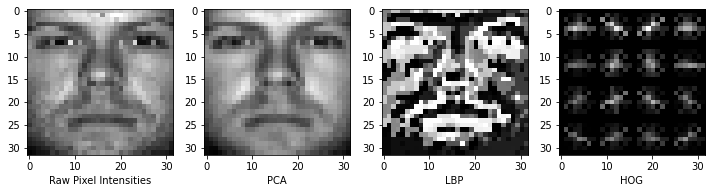

In [88]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from skimage.feature import local_binary_pattern as LBP
from skimage.feature import hog
import matplotlib.pyplot as plt

img = np.transpose(np.reshape(fea[0,:], (32, 32)))
pca = PCA().fit(fea)
pca_variance = pca.explained_variance_ratio_.cumsum()
PCA_95_pt = np.where(pca_variance > 0.95)[0][0]
pca = PCA(n_components=PCA_95_pt).fit(fea)
fea_pca = pca.transform(fea)
fea_PC = pca.inverse_transform(fea_pca)

# plt.imshow(np.transpose(fea_PC[0].reshape(32, 32)), cmap = plt.cm.gray)
# plt.show()
# plt.imshow(np.transpose(fea_LD[0].reshape(32, 32)), cmap = plt.cm.gray)

img = np.transpose(np.reshape(fea[0,:], (32, 32)))
hog_dat, img_hog = hog(img, visualize=True)
img_lbp = img_lbp = LBP(img, 8, 2)

plt.figure(figsize=(10,3))
plt.subplot(141)
plt.imshow(img, cmap = plt.cm.gray)
plt.xlabel('Raw Pixel Intensities')
plt.subplot(142)
plt.imshow(np.transpose(fea_PC[0].reshape(32, 32)), cmap = plt.cm.gray)
plt.xlabel('PCA')
plt.subplot(143)
plt.imshow(img_lbp, cmap = plt.cm.gray)
plt.xlabel('LBP')
plt.subplot(144)
plt.imshow(img_hog, cmap = plt.cm.gray)
plt.xlabel('HOG')
plt.tight_layout()
plt.savefig('Images/features.png')

## 1. EigenFaces

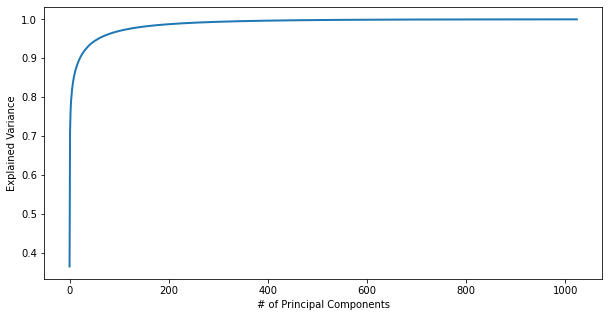

58


In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA().fit(fea_train)
pca_variance = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(10, 5))
plt.plot(pca_variance, lw=2)
plt.xlabel('# of Principal Components')
plt.ylabel('Explained Variance')
plt.savefig('Images/PCA_variance.png')
plt.show()

#95% variance point
PCA_95_pt = np.where(pca_variance > 0.95)[0][0]
print(PCA_95_pt)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=PCA_95_pt).fit(fea_train)
fea_train_pca = pca.transform(fea_train)
fea_test_pca = pca.transform(fea_test)

neigh = KNeighborsClassifier(n_neighbors=1, p = 2)
neigh.fit(fea_train_pca, np.ravel(gnd_train))
acc = neigh.score(fea_test, gnd_test)
print('mean accuracy: ', acc*100, '%')
print('classification error rate: ', (1 - acc)*100, '%')

mean accuracy:  36.234021632251725 %
classification error rate:  63.765978367748275 %


[0.6381514257620453, 0.5332527206771462, 0.4678178963893249, 0.4250559284116331, 0.3929961089494164]


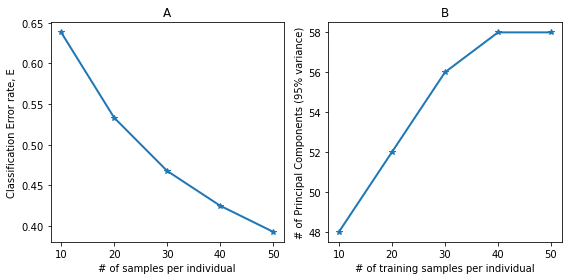

In [27]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
# loop through the m
err_PCA = []
PCs_95 = []
for m in np.arange(10,51,10):
    np.random.seed(1000)
    fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
    pca = PCA().fit(fea_train)
    pca_variance = pca.explained_variance_ratio_.cumsum()
    PCA_95_pt = np.where(pca_variance > 0.95)[0][0]
    PCs_95.append(PCA_95_pt)
    pca = PCA(n_components=PCA_95_pt).fit(fea_train)
    fea_train_pca = pca.transform(fea_train)
    fea_test_pca = pca.transform(fea_test)
    neigh = KNeighborsClassifier(n_neighbors=1, p = 2)
    neigh.fit(fea_train_pca, np.ravel(gnd_train))
    acc = neigh.score(fea_test_pca, np.ravel(gnd_test))
    err_PCA.append(1-acc)

print(err_PCA)
m = np.arange(10,51,10)
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(m, err_PCA, '-*', lw=2)
plt.xlabel('# of samples per individual')
plt.ylabel('Classification Error rate, E')
plt.title('A')
plt.subplot(122)
plt.plot(m, PCs_95, '-*', lw=2)
plt.xlabel('# of training samples per individual')
plt.ylabel('# of Principal Components (95% variance)')
plt.title('B')
plt.tight_layout()
plt.savefig('Images/PCA_E_rate.png')
plt.show()

## 2. Fisherfaces

[0.2064896755162242, 0.13845223700120923, 0.2189952904238619, 0.07158836689038028, 0.027237354085603127]


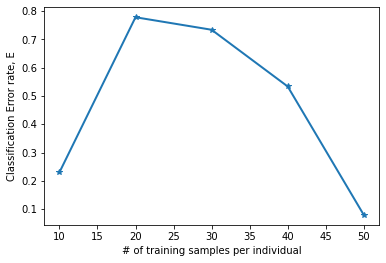

In [82]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# loop through the m
err_FF = []
C = np.unique(gnd_train).shape[0]
for m in np.arange(10,51,10):
    np.random.seed(1000)
    fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
    lda = LDA(n_components=C-1)
    fea_train_lda = lda.fit_transform(fea_train, np.ravel(gnd_train))
    fea_test_lda = lda.transform(fea_test)
    neigh = KNeighborsClassifier(n_neighbors=1, p = 2)
    neigh.fit(fea_train_lda, np.ravel(gnd_train))
    acc = neigh.score(fea_test_lda, np.ravel(gnd_test))
#     acc = lda.score(fea_test, gnd_test)
    err_FF.append(1-acc)

print(err_FF)
m = np.arange(10,51,10)
plt.plot(m, err_arr, '-*', lw=2)
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.savefig('Images/Fisherface_E_rate.png')
plt.show()

# 3. SVM

38
[0.2010816125860374, 0.18802902055622728, 0.14913657770800626, 0.14317673378076068, 0.11867704280155644]


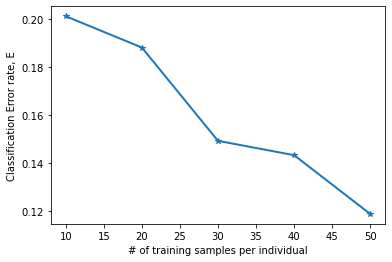

In [60]:
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")
# loop through the m
err_SVM = []
C = np.unique(gnd_train).shape[0]
print(C)
for m in np.arange(10,51,10):
    np.random.seed(1000)
    fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
    model = svm.LinearSVC()
    model.fit(fea_train, np.ravel(gnd_train))
    acc = model.score(fea_test, np.ravel(gnd_test))
    err_SVM.append(1-acc)
    
print(err_SVM)
m = np.arange(10,51,10)
plt.plot(m, err_SVM, '-*', lw=2)
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.savefig('Images/SVM_E_rate.png')
plt.show()

### 3.b SVM-PCA

48
52
56
58
58
[0.8490658800393314, 0.8246674727932285, 0.8383045525902668, 0.8087248322147651, 0.7062256809338521]


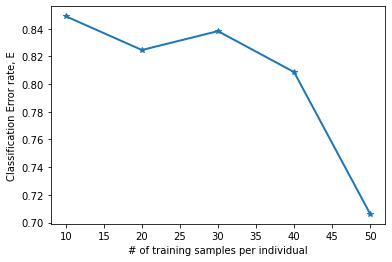

In [30]:
from sklearn.decomposition import PCA
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")
# loop through the m
err_SVM_PCA = []
for m in np.arange(10,51,10):
    np.random.seed(1000)
    fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
    pca = PCA().fit(fea_train)
    pca_variance = pca.explained_variance_ratio_.cumsum()
    PCA_95_pt = np.where(pca_variance > 0.95)[0][0]
    print(PCA_95_pt)
    pca = PCA(n_components=PCA_95_pt).fit(fea_train)
    fea_train_pca = pca.transform(fea_train)
    fea_test_pca = pca.transform(fea_test)
    model = svm.LinearSVC()
    model.fit(fea_train_pca, np.ravel(gnd_train))
    acc = model.score(fea_test_pca, np.ravel(gnd_test))
    err_SVM_PCA.append(1-acc)
    
print(err_SVM_PCA)
m = np.arange(10,51,10)
plt.plot(m, err_SVM_PCA, '-*', lw=2)
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.savefig('Images/SVM_PCA_E_rate.png')
plt.show()

### 3.c. SVM-LDA

38
[0.23008849557522126, 0.7781136638452237, 0.7339089481946625, 0.5335570469798658, 0.0797665369649806]


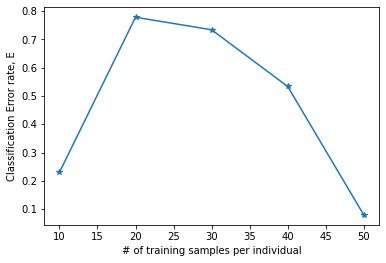

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# loop through the m
err_SVM_LDA = []
C = np.unique(gnd_train).shape[0]
print(C)
for m in np.arange(10,51,10):
    np.random.seed(1000)
    fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
    lda = LDA(n_components=C-1)
    fea_train_lda = lda.fit_transform(fea_train, np.ravel(gnd_train))
    fea_test_lda = lda.transform(fea_test)
    model = svm.LinearSVC()
    model.fit(fea_train_lda, np.ravel(gnd_train))
    acc = model.score(fea_test_lda, np.ravel(gnd_test))
    err_SVM_LDA.append(1-acc)

print(err_SVM_LDA)
m = np.arange(10,51,10)
plt.plot(m, err_SVM_LDA, '-*')
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.savefig('Images/SVM_LDA_E_rate.png')
plt.show()

### 3.d. SVM-LBP

(2034, 1024)
(380, 1024)
(1654, 1024)
(760, 1024)
(1274, 1024)
(1140, 1024)
(894, 1024)
(1520, 1024)
(514, 1024)
(1900, 1024)
[0.008849557522123908, 0.0036275695284159193, 0.0023547880690737433, 0.0011185682326622093, 0.0]


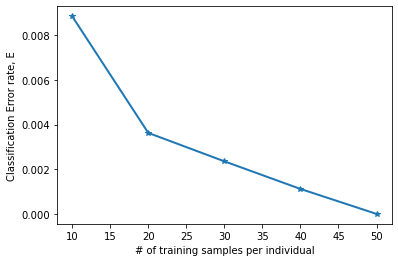

In [36]:
from skimage.feature import local_binary_pattern as LBP

# loop through the m
err_SVM_LBP = []
for m in np.arange(10,51,10):
    np.random.seed(1000)
    fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
    img = np.transpose(np.reshape(fea_train[1,:], (32, 32)))
    img_lbp = LBP(img, 8, 2)
    img_lbp = np.ravel(img_lbp)
    fea_train_lbp = np.zeros((fea_train.shape[0], img_lbp.shape[0]))
    fea_test_lbp = np.zeros((fea_test.shape[0], img_lbp.shape[0]))
    print(fea_test_lbp.shape)
    print(fea_train_lbp.shape)
    for i in np.arange(0, fea_train.shape[0]):
        img = np.transpose(np.reshape(fea_train[i,:], (32, 32)))
        img_lbp = LBP(img, 8, 2)
        fea_train_lbp[i,:] = np.ravel(img_lbp)
        

    for i in np.arange(0, fea_test.shape[0]):
        img = np.transpose(np.reshape(fea_test[i,:], (32, 32)))
        img_lbp = LBP(img, 8, 2)
        fea_test_lbp[i,:] = np.ravel(img_lbp)
        
    model = svm.LinearSVC()
    model.fit(fea_train_lbp, np.ravel(gnd_train))
    acc = model.score(fea_test_lbp, np.ravel(gnd_test))
    err_SVM_LBP.append(1-acc)

print(err_SVM_LBP)
m = np.arange(10,51,10)
plt.plot(m, err_SVM_LBP, '-*', lw=2)
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.savefig('Images/SVM_LBP.png')
plt.show()

### 3.e. SVM-HOG

(2034, 324)
(380, 324)
(1654, 324)
(760, 324)
(1274, 324)
(1140, 324)
(894, 324)
(1520, 324)
(514, 324)
(1900, 324)
[0.46804326450344147, 0.3814993954050786, 0.30141287284144425, 0.2539149888143176, 0.23929961089494167]


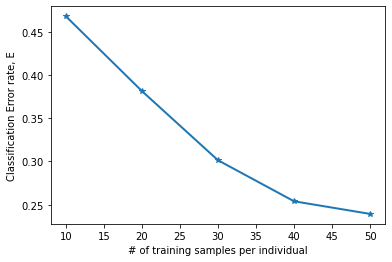

In [38]:
from skimage.feature import hog

# loop through the m
err_SVM_HOG = []
for m in np.arange(10,51,10):
    np.random.seed(1000)
    fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
    img = np.transpose(np.reshape(fea_train[1,:], (32, 32)))
    img_hog = hog(img)
    fea_train_hog = np.zeros((fea_train.shape[0], img_hog.shape[0]))
    fea_test_hog = np.zeros((fea_test.shape[0], img_hog.shape[0]))
    print(fea_test_hog.shape)
    print(fea_train_hog.shape)
    for i in np.arange(0, fea_train.shape[0]):
        img = np.transpose(np.reshape(fea_train[i,:], (32, 32)))
        img_hog = hog(img)
        fea_train_hog[i,:] = img_hog
        

    for i in np.arange(0, fea_test.shape[0]):
        img = np.transpose(np.reshape(fea_test[i,:], (32, 32)))
        img_hog = hog(img)
        fea_test_hog[i,:] = img_hog
        
    model = svm.LinearSVC()
    model.fit(fea_train_hog, np.ravel(gnd_train))
    acc = model.score(fea_test_hog, np.ravel(gnd_test))
    err_SVM_HOG.append(1-acc)
    
print(err_SVM_HOG)
m = np.arange(10,51,10)
plt.plot(m, err_SVM_HOG, '-*', lw=2)
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.savefig('Images/SVM_HOG_E_rate.png')
plt.show()

### Variants of SVMs Plots

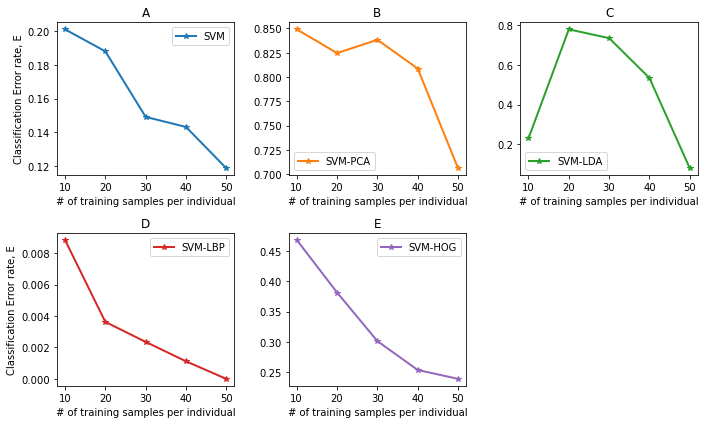

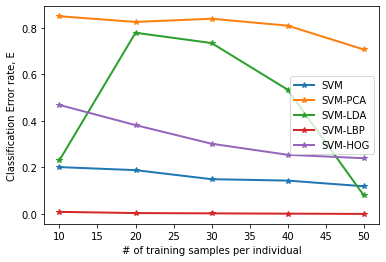

In [110]:
plt.figure(figsize=(10,6))
plt.subplot(231)
plt.title('A')
plt.plot(m, err_SVM, 'C0-*', lw=2, label='SVM')
plt.xlabel('# of training samples per individual')
plt.legend()
plt.ylabel('Classification Error rate, E')
plt.subplot(232)
plt.title('B')
plt.plot(m, err_SVM_PCA, 'C1-*', lw=2, label='SVM-PCA')
plt.xlabel('# of training samples per individual')
plt.legend()
plt.subplot(233)
plt.title('C')
plt.plot(m, err_SVM_LDA, 'C2-*', lw=2, label='SVM-LDA')
plt.xlabel('# of training samples per individual')
plt.legend()
plt.subplot(234)
plt.title('D')
plt.plot(m, err_SVM_LBP, 'C3-*', lw=2, label='SVM-LBP')
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.legend()
plt.subplot(235)
plt.title('E')
plt.plot(m, err_SVM_HOG, 'C4-*', lw=2, label='SVM-HOG')
plt.xlabel('# of training samples per individual')

plt.legend()
plt.tight_layout()
plt.savefig('Images/All_Algo_E_rate_grid.png')
plt.show()

plt.figure()
m = np.arange(10,51,10)
plt.plot(m, err_SVM, '-*', lw=2, label='SVM')
plt.plot(m, err_SVM_PCA, '-*', lw=2, label='SVM-PCA')
plt.plot(m, err_SVM_LDA, '-*', lw=2, label='SVM-LDA')
plt.plot(m, err_SVM_LBP, '-*', lw=2, label='SVM-LBP')
plt.plot(m, err_SVM_HOG, '-*', lw=2, label='SVM-HOG')
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.legend()
plt.savefig('Images/All_Algo_E_rate.png')
plt.show()

### 4. SRC algorithm

In [89]:
from sklearn.decomposition import sparse_encode
import numpy as np

def SRC_Classifier(x_train, y_train, x_test, y_test):
    Dict = np.float32(x_train)
    codes = sparse_encode(np.float32(x_test), Dict, algorithm='omp')
    y_pred = np.array([])
    for j in np.arange(0, x_test.shape[0]):
        Res = np.array([])
        for i in np.arange(0, 38):
            Res_i = np.linalg.norm(x_test[j,:] - np.matmul(codes[j,i*m:(i+1)*m], Dict[i*m:(i+1)*m, :]))
            Res = np.append(Res, Res_i)
        y_pred_norm = np.min(Res)
        y_pred_j = np.where(Res == y_pred_norm)[0][0] + 1
        y_pred = np.append(y_pred, y_pred_j)
    return y_pred

def clf_score(y_predt, y_test):
    Miss_Class_idx = []
    Miss_Class_label = []
    for i in np.arange(len(y_predt)):
        if y_predt[i] != y_test[i]:
            Miss_Class_idx.append(i)
            Miss_Class_label.append(y_predt[i])
    Cls_Err_Rate = (len(Miss_Class_idx)/len(y_test))
    print('Classification Error Rate :', Cls_Err_Rate)
    return Cls_Err_Rate, Miss_Class_idx, Miss_Class_label

In [90]:
# loop through the m
err_SRC = []
for m in np.arange(10,51,10):
    np.random.seed(1000)
    fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
    y_pred = SRC_Classifier(fea_train, gnd_train, fea_test, gnd_test)
    err, mc_idx, mc_lbl = clf_score(y_pred, gnd_test)
    err_SRC.append(err)
    
print(err_SRC)

Classification Error Rate : 0.0855457227138643
Classification Error Rate : 0.042926239419588876
Classification Error Rate : 0.01805337519623234
Classification Error Rate : 0.015659955257270694
Classification Error Rate : 0.013618677042801557
[0.0855457227138643, 0.042926239419588876, 0.01805337519623234, 0.015659955257270694, 0.013618677042801557]


[0.0855457227138643, 0.042926239419588876, 0.01805337519623234, 0.015659955257270694, 0.013618677042801557]


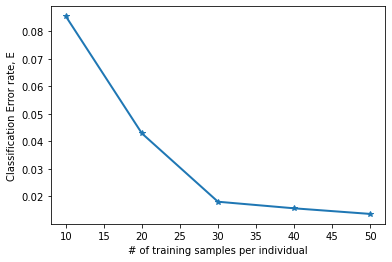

In [91]:
import matplotlib.pyplot as plt
print(err_SRC)
m = np.arange(10,51,10)
plt.plot(m, err_SRC, '-*', lw=2)
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.savefig('Images/SRC_E_rate.png')
plt.show()

### 4. b. SRC-PCA

In [92]:
# loop through the m
err_SRC_PCA = []
for m in np.arange(10,51,10):
    np.random.seed(1000)
    fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
    pca = PCA().fit(fea_train)
    pca_variance = pca.explained_variance_ratio_.cumsum()
    PCA_95_pt = np.where(pca_variance > 0.95)[0][0]
    pca = PCA(n_components=PCA_95_pt).fit(fea_train)
    fea_train_pca = pca.transform(fea_train)
    fea_test_pca = pca.transform(fea_test)
    y_pred = SRC_Classifier(fea_train_pca, gnd_train, fea_test_pca, gnd_test)
    err, mc_idx, mc_lbl = clf_score(y_pred, gnd_test)
    err_SRC_PCA.append(err)
    
print(err_SRC_PCA)

Classification Error Rate : 0.6179941002949852
Classification Error Rate : 0.4703748488512696
Classification Error Rate : 0.42464678178963894
Classification Error Rate : 0.39038031319910516
Classification Error Rate : 0.38715953307393
[0.6179941002949852, 0.4703748488512696, 0.42464678178963894, 0.39038031319910516, 0.38715953307393]


[0.6179941002949852, 0.4703748488512696, 0.42464678178963894, 0.39038031319910516, 0.38715953307393]


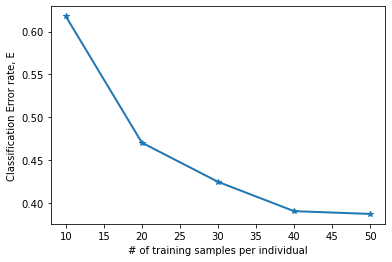

In [93]:
import matplotlib.pyplot as plt
print(err_SRC_PCA)
m = np.arange(10,51,10)
plt.plot(m, err_SRC_PCA, '-*', lw=2)
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.savefig('Images/SRC_PCA_E_rate.png')
plt.show()

### 4.c. SRC-LDA

In [94]:
# loop through the m
err_SRC_LDA = []
C = np.unique(gnd_train).shape[0]
print(C)
for m in np.arange(10,51,10):
    np.random.seed(1000)
    fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
    lda = LDA(n_components=C-1)
    fea_train_lda = lda.fit_transform(fea_train, np.ravel(gnd_train))
    fea_test_lda = lda.transform(fea_test)
    y_pred = SRC_Classifier(fea_train_lda, gnd_train, fea_test_lda, gnd_test)
    err, mc_idx, mc_lbl = clf_score(y_pred, gnd_test)
    err_SRC_LDA.append(err)
    
print(err_SRC_LDA)

38
Classification Error Rate : 0.1863323500491642
Classification Error Rate : 0.13422007255139057
Classification Error Rate : 0.347723704866562
Classification Error Rate : 0.06263982102908278
Classification Error Rate : 0.021400778210116732
[0.1863323500491642, 0.13422007255139057, 0.347723704866562, 0.06263982102908278, 0.021400778210116732]


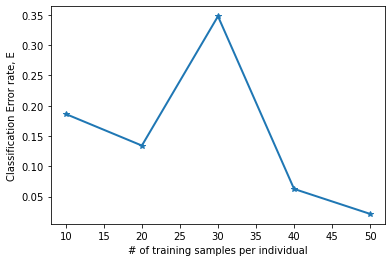

In [95]:
m = np.arange(10,51,10)
plt.plot(m, err_SRC_LDA, '-*', lw=2)
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.savefig('SRC_LDA_E_rate.png')
plt.show()

### 4.d. SRC-LBP

In [96]:
# loop through the m
err_SRC_LBP = []
C = np.unique(gnd_train).shape[0]
print(C)
for m in np.arange(10,51,10):
    np.random.seed(1000)
    fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
    img = np.transpose(np.reshape(fea_train[1,:], (32, 32)))
    img_lbp = LBP(img, 8, 2)
    img_lbp = np.ravel(img_lbp)
    fea_train_lbp = np.zeros((fea_train.shape[0], img_lbp.shape[0]))
    fea_test_lbp = np.zeros((fea_test.shape[0], img_lbp.shape[0]))
    for i in np.arange(0, fea_train.shape[0]):
        img = np.transpose(np.reshape(fea_train[i,:], (32, 32)))
        img_lbp = LBP(img, 8, 2)
        fea_train_lbp[i,:] = np.ravel(img_lbp)
        
    for i in np.arange(0, fea_test.shape[0]):
        img = np.transpose(np.reshape(fea_test[i,:], (32, 32)))
        img_lbp = LBP(img, 8, 2)
        fea_test_lbp[i,:] = np.ravel(img_lbp)
    y_pred = SRC_Classifier(fea_train_lbp, gnd_train, fea_test_lbp, gnd_test)
    err, mc_idx, mc_lbl = clf_score(y_pred, gnd_test)
    err_SRC_LBP.append(err)

  
print(err_SRC_LBP)

38
Classification Error Rate : 0.005408062930186824
Classification Error Rate : 0.0024183796856106408
Classification Error Rate : 0.003924646781789639
Classification Error Rate : 0.0
Classification Error Rate : 0.0
[0.005408062930186824, 0.0024183796856106408, 0.003924646781789639, 0.0, 0.0]


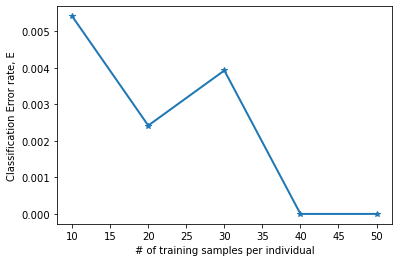

In [97]:
m = np.arange(10,51,10)
plt.plot(m, err_SRC_LBP, '-*', lw=2)
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.savefig('SRC_LBP_E_rate.png')
plt.show()

### 4.e. SRC-HOG

In [98]:
# loop through the m
err_SRC_HOG = []
C = np.unique(gnd_train).shape[0]
print(C)
for m in np.arange(10,51,10):
    np.random.seed(1000)
    fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
    img = np.transpose(np.reshape(fea_train[1,:], (32, 32)))
    img_hog = hog(img)
    fea_train_hog = np.zeros((fea_train.shape[0], img_hog.shape[0]))
    fea_test_hog = np.zeros((fea_test.shape[0], img_hog.shape[0]))
    for i in np.arange(0, fea_train.shape[0]):
        img = np.transpose(np.reshape(fea_train[i,:], (32, 32)))
        img_hog = hog(img)
        fea_train_hog[i,:] = img_hog
        
    for i in np.arange(0, fea_test.shape[0]):
        img = np.transpose(np.reshape(fea_test[i,:], (32, 32)))
        img_hog = hog(img)
        fea_test_hog[i,:] = img_hog
    y_pred = SRC_Classifier(fea_train_hog, gnd_train, fea_test_hog, gnd_test)
    err, mc_idx, mc_lbl = clf_score(y_pred, gnd_test)
    err_SRC_HOG.append(err)

  
print(err_SRC_HOG)

38
Classification Error Rate : 0.5117994100294986
Classification Error Rate : 0.40386940749697703
Classification Error Rate : 0.38226059654631084
Classification Error Rate : 0.3523489932885906
Classification Error Rate : 0.3424124513618677
[0.5117994100294986, 0.40386940749697703, 0.38226059654631084, 0.3523489932885906, 0.3424124513618677]


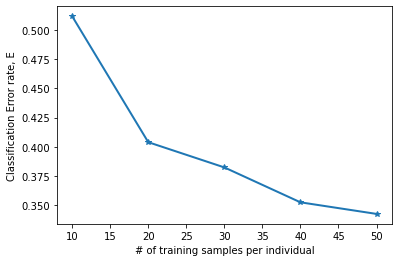

In [99]:
m = np.arange(10,51,10)
plt.plot(m, err_SRC_HOG, '-*', lw=2)
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.savefig('SRC_HOG_E_rate.png')
plt.show()

### Variants of SRCs Plots

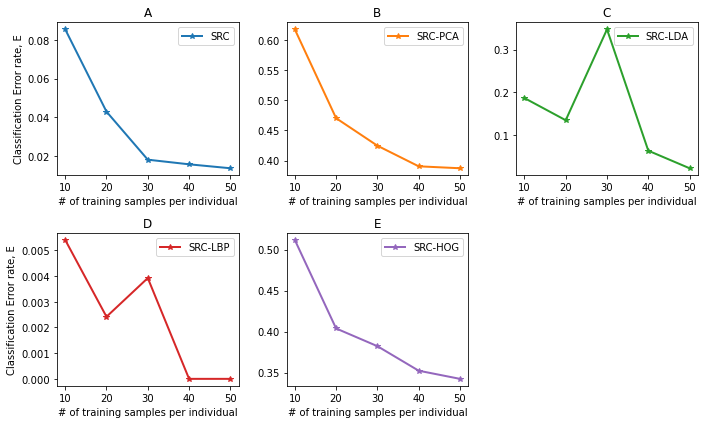

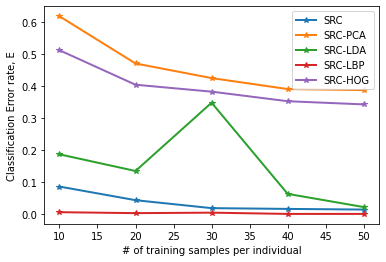

In [108]:
plt.figure(figsize=(10,6))
plt.subplot(231)
plt.title('A')
plt.plot(m, err_SRC, 'C0-*', lw=2, label='SRC')
plt.xlabel('# of training samples per individual')
plt.legend()
plt.ylabel('Classification Error rate, E')
plt.subplot(232)
plt.title('B')
plt.plot(m, err_SRC_PCA, 'C1-*', lw=2, label='SRC-PCA')
plt.xlabel('# of training samples per individual')
plt.legend()
plt.subplot(233)
plt.title('C')
plt.plot(m, err_SRC_LDA, 'C2-*', lw=2, label='SRC-LDA')
plt.xlabel('# of training samples per individual')
plt.legend()
plt.subplot(234)
plt.title('D')
plt.plot(m, err_SRC_LBP, 'C3-*', lw=2, label='SRC-LBP')
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.legend()
plt.subplot(235)
plt.title('E')
plt.plot(m, err_SRC_HOG, 'C4-*', lw=2, label='SRC-HOG')
plt.xlabel('# of training samples per individual')

plt.legend()
plt.tight_layout()
plt.savefig('Images/All_Algo_SRC_E_rate_grid.png')
plt.show()

plt.figure()
m = np.arange(10,51,10)
plt.plot(m, err_SRC, '-*', lw=2, label='SRC')
plt.plot(m, err_SRC_PCA, '-*', lw=2, label='SRC-PCA')
plt.plot(m, err_SRC_LDA, '-*', lw=2, label='SRC-LDA')
plt.plot(m, err_SRC_LBP, '-*', lw=2, label='SRC-LBP')
plt.plot(m, err_SRC_HOG, '-*', lw=2, label='SRC-HOG')
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.legend()
plt.savefig('Images/All_Algo_SRC_E_rate.png')
plt.show()

### plot all 4 algorithm losses

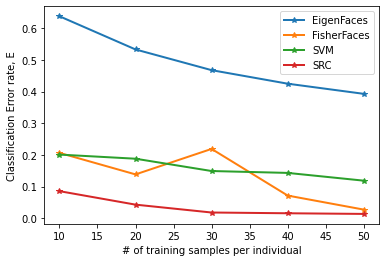

In [101]:
plt.figure()
m = np.arange(10,51,10)
plt.plot(m, err_PCA, '-*', lw=2, label='EigenFaces')
plt.plot(m, err_FF, '-*', lw=2, label='FisherFaces')
plt.plot(m, err_SVM, '-*', lw=2, label='SVM')
plt.plot(m, err_SRC, '-*', lw=2, label='SRC')
plt.xlabel('# of training samples per individual')
plt.ylabel('Classification Error rate, E')
plt.legend()
plt.savefig('Images/All_Algo_E_rate.png')
plt.show()

In [8]:
from sklearn.decomposition import SparseCoder
import numpy as np
m = 40
np.random.seed(1000)
fea_train, gnd_train, fea_test, gnd_test = data_split(fea, gnd, m)
Dict = np.float32(fea_train)
coder = SparseCoder(dictionary=Dict, transform_algorithm='omp', transform_alpha=1e-10)
codes = coder.transform(fea_test)